In [1]:
import sys

import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import os
from datetime import datetime
import time
import glob
import random
import PIL.Image as Image
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from skimage.measure import regionprops
from torch.utils.data import Dataset, DataLoader

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

Albumentations

In [2]:
def get_train_transforms():
    return A.Compose(
        [
            # A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.augmentations.transforms.Normalize(p=1.0),
            # A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

Dataset

In [3]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns 
        - numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [4]:
class AirbusDS(Dataset):
    """
    A customized data loader.
    """
    def __init__(
        self, dataset_root="/workspace/dataset", aug=False, mode='train'
        ):
        """ Intialize the dataset
        """
        self.filenames = []
        self.root = dataset_root
        self.aug = aug
        self.mode = 'test'
        if mode == 'train':
            self.mode = 'train'
            self.masks = pd.read_csv(os.path.join(self.root, 'train_extracted.csv')).fillna(-1)
        if self.aug:
            self.transform = get_train_transforms()
        else:
            self.transform = get_valid_transforms()
        
        self.filenames = [os.path.join(self.root, "train_v2", fstem) for fstem in list(self.masks["ImageId"])]
        self.len = len(self.filenames)

    # You must override __getitem__ and __len__
    def get_mask_boxes(self, ImageId):
        img_masks = self.masks.loc[self.masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()
        bboxes = []
        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768))
        if img_masks == [-1]:
            return all_masks, bboxes
        for mask in img_masks:
            target_mask = rle_decode(mask)
            props = regionprops(target_mask)
            for prop in props:
                bboxes.append(
                    [prop.bbox[1], prop.bbox[0], prop.bbox[3], prop.bbox[2]]
                )
            all_masks += target_mask
        return all_masks, bboxes

    def calc_area(self, bboxes, mode="pascal_voc"):
        area = []
        if mode == "pascal_voc":
            for bbox in bboxes:
                w = bbox[2] - bbox[0]
                h = bbox[3] - bbox[1]
                area.append(w*h)    
        else:
            raise NotImplementedError()

        return area

    def __getitem__(self, idx):
        """ Get a sample from the dataset
        """
        image = Image.open(self.filenames[idx])
        ImageId = self.filenames[idx].split('/')[-1]
        if self.mode == 'train':
            mask, bbox = self.get_mask_boxes(ImageId)
        if self.aug:
            if self.mode == 'train':
                data = {
                    "image": np.array(image),
                    "mask": mask,
                    "bboxes": bbox,
                    "labels": np.array(["ship" for _ in bbox]),
                }
            else:
                data = {"image": np.array(image)}
            transformed = self.transform(**data)
            image = transformed["image"]
            if self.mode == 'train':
                if self.mode == 'train':
                    num_objs = len(bbox)
                    target = {}
                    target["boxes"] = torch.as_tensor(transformed["bboxes"], dtype=torch.float32)
                    # print(target["boxes"].shape)
                    target["masks"] = transformed["mask"][np.newaxis, : ,:].to(torch.uint8)
                    target["labels"] = torch.ones((num_objs, ), dtype=torch.int64)
                    target["area"] = torch.Tensor(self.calc_area(transformed["bboxes"]))
                    target["iscrowd"] = torch.zeros((num_objs, ), dtype=torch.int64)
                    target["image_id"] = torch.Tensor([idx])
                return image, target
            else:
                return image
        else:
            raise NotImplementedError()

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [5]:
dataset = AirbusDS(dataset_root="/workspace/dataset", aug=True)
image, target = dataset[1]

test output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([275.3333, 359.3333, 399.3333, 400.0000])
tensor([382.0000, 365.3333, 394.6667, 376.0000])
tensor([367.3333, 396.0000, 378.0000, 412.6667])
tensor([281.3333, 383.3333, 289.3333, 387.3333])


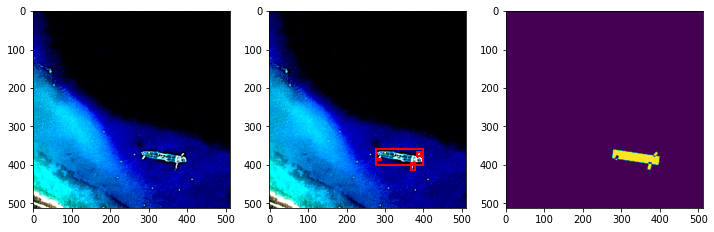

In [6]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.imshow(image.numpy().transpose(1, 2, 0))
ax2.imshow(image.numpy().transpose(1, 2, 0))
for bbox in target["boxes"]:
    print(bbox)
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), 
        bbox[2] - bbox[0], 
        bbox[3] - bbox[1],
        linewidth = 2,
        edgecolor="red",
        facecolor=None,
        fill=False
    )
    ax2.add_patch(rect)

ax3.imshow(target["masks"].numpy().transpose(1, 2, 0))

Model creation

In [7]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [8]:
model = get_model_instance_segmentation(num_classes=2)
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

test forward()

In [9]:
def collate_fn(batch):
    images, labels = tuple(zip(*batch))
    labels = [{k: v for k, v in t.items()} for t in labels]
    return [images, labels]

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

model.to("cpu")
images, targets = next(iter(data_loader))
print(images[0].shape)
print(targets[0]["masks"].shape)

# targets["boxes"] = targets["boxes"][0]
# targets["labels"] = targets["labels"][0]
output = model(images, targets)
output

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


{'loss_classifier': tensor(0.3971, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1685, grad_fn=<DivBackward0>),
 'loss_mask': tensor(1.6748, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.9982, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.8334, grad_fn=<DivBackward0>)}

In [10]:
train_dataloader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=3,
    collate_fn=collate_fn
)

In [11]:
EPOCHS = 5
clipping_value = 5
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.train()
model.to(device)

for epoch in range(EPOCHS):

    for i, batch in enumerate(train_dataloader):
        images, targets = batch
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
        optimizer.step()
 
        if (i + 1) % 10 == 0:
          print(f"epoch #{epoch + 1} Iteration #{i + 1} loss: {loss_value}")  

epoch #1 Iteration #10 loss: 3.2262635231018066
epoch #1 Iteration #20 loss: 1.735795497894287
epoch #1 Iteration #30 loss: 1.5866228342056274
epoch #1 Iteration #40 loss: 1.5275273323059082
epoch #1 Iteration #50 loss: 2.0880796909332275
epoch #1 Iteration #60 loss: 0.8876438736915588
epoch #1 Iteration #70 loss: 1.2022068500518799
epoch #1 Iteration #80 loss: 1.1849219799041748
epoch #1 Iteration #90 loss: 2.2549960613250732
epoch #1 Iteration #100 loss: 0.9271563291549683
epoch #1 Iteration #110 loss: 1.1246142387390137
epoch #1 Iteration #120 loss: 1.4649817943572998
epoch #1 Iteration #130 loss: 1.0425662994384766
epoch #1 Iteration #140 loss: 1.8789981603622437
epoch #1 Iteration #150 loss: 0.8776026368141174
epoch #1 Iteration #160 loss: 1.359560251235962
epoch #1 Iteration #170 loss: 1.1230894327163696
epoch #1 Iteration #180 loss: 1.0274839401245117
epoch #1 Iteration #190 loss: 1.6491461992263794
epoch #1 Iteration #200 loss: 1.6314677000045776
epoch #1 Iteration #210 loss: 1

KeyboardInterrupt: 

In [12]:
torch.save(model, "/workspace/output/weight_7560.pth")

Inference

In [37]:
model.eval()
images, targets = next(iter(train_dataloader))
images = list(image.to(device) for image in images)
output = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


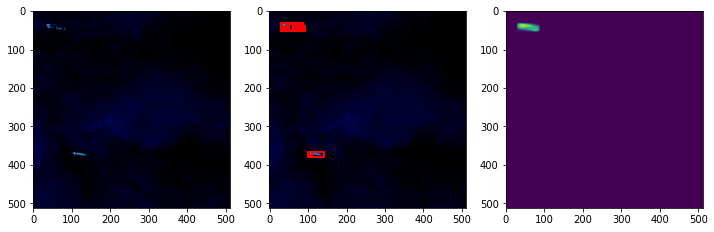

In [38]:
idx = 0

image = images[idx].to("cpu").numpy().transpose(1, 2, 0)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.imshow(image)
ax2.imshow(image)
for bbox in output[idx]["boxes"].to("cpu").detach().numpy():
    if max(bbox) > 512 or min(bbox) < 0:
        continue
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), 
        bbox[2] - bbox[0], 
        bbox[3] - bbox[1],
        linewidth = 2,
        edgecolor="red",
        facecolor=None,
        fill=False
    )
    ax2.add_patch(rect)

ax3.imshow(output[0]["masks"][0].to("cpu").detach().numpy().transpose(1, 2, 0))